In [1]:
import warnings

from typing import (Union, NoReturn, Optional,
                    Tuple, List)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('seaborn-darkgrid')
np.random.seed(0)

%matplotlib inline

In [2]:
train = pd.read_csv('../input/liverpool-ion-switching/train.csv')
test = pd.read_csv('../input/liverpool-ion-switching/test.csv')

In [3]:
# data comes in batches of 500,000. This is given
batch_size = 500_000
train.shape, test.shape

((5000000, 3), (2000000, 2))

In [4]:
# Find the number of batches in both train and test dataset
len(train) // batch_size, len(test) // batch_size

(10, 4)

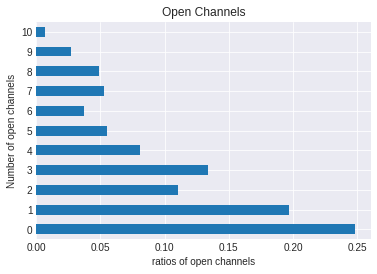

In [5]:
train['open_channels'].value_counts(normalize=True, sort=False).plot.barh()
plt.xlabel('ratios of open channels')
plt.ylabel('Number of open channels')
plt.title('Open Channels')
plt.show()

The traning data has 5 million rows, i.e., it has 10 batch recording, each batch consisting of 500,000 recordings. The test set on the other hand, has 4 batch.
There are 11 values for `open_channels`: `0` through `11`. The majority of these values are `0`, i.e, no channel open and only `1` channel open.

In [6]:
def plot_time_series(data: pd.DataFrame, 
                     start: int, 
                     stop: int, 
                     step: int = 100) -> NoReturn:
    '''
    A utility function to help plot the signal data.
    Plots signal and open_channels vs time
    
    @param data: the time series signal data that is to be plot
    @param start: Since the time series is very long, a start index to consider data only after
    @param step: Steps to skip. Useful to get a cleaner plot
    '''
    
    # make sure all params are proper
    assert stop > start, 'Improper arguments: stop index has to be greater than start index'
    
    plt.figure(figsize=(12, 6))
    plt.plot(data.loc[start:stop:step, 'time'], data.loc[start:stop:step, 'open_channels'], linewidth=0.7)
    plt.plot(data.loc[start:stop:step, 'time'], data.loc[start:stop:step, 'signal'], linewidth=0.7)
    
    plt.title(f'Signal and open channel in [{start}, {stop}). Total seconds = {(stop - start) / 1e4}')
    plt.xlabel('time')
    plt.legend(['Open channels', 'Signal'])
    
    plt.show()

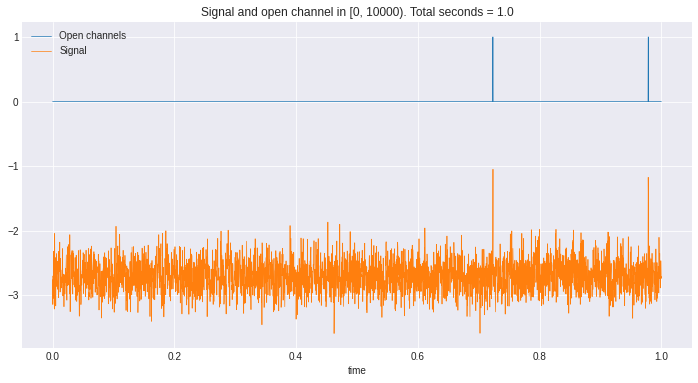

In [7]:
# plot the first second of the data
plot_time_series(train, 0, 10000, 3)

This is a plot for 1 second, of the training data. The signal veries from about -3 all the way upto -1. Only when the the signal exceeds -2 threshold does it have a chance of firing. There's a high correleation between signal and open channels

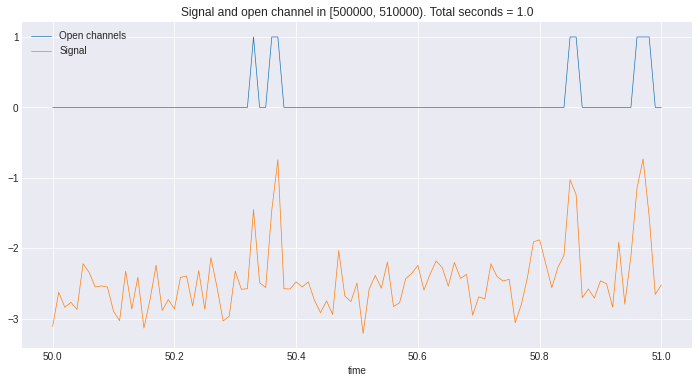

In [8]:
# plot the first second of the second batch
plot_time_series(train, 500000, 510000)

This is a plot of the first second of the second batch. As was in the previous plot channels only open when a certain threshold is crossed

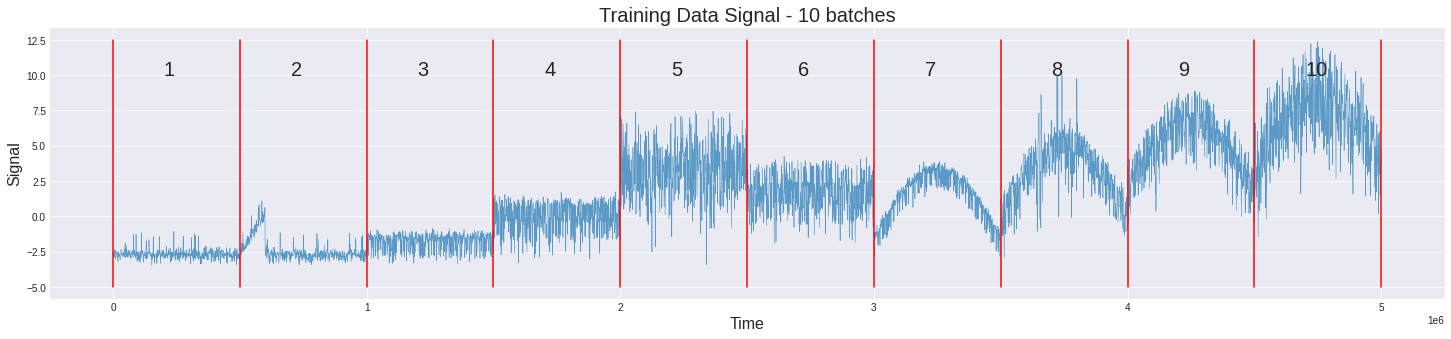

In [9]:
step = 1000
plt.figure(figsize=(25, 5))

# plot signal in steps of `step(=1000)`
plt.plot(range(0, len(train), step), train.loc[::step, 'signal'], alpha=0.7, linewidth=0.6)

# highlight the start and the end of each batch
for i in range(11):
    plt.plot([i * batch_size, i * batch_size], [-5, 12.5], 'r')

# mark which batch it came from
for i in range(10):
    plt.text(i * batch_size + 200000, 10, str(i + 1), size=20)

plt.xlabel('Time', size=16)
plt.ylabel('Signal', size=16)

plt.title('Training Data Signal - 10 batches',size=20)

plt.show()

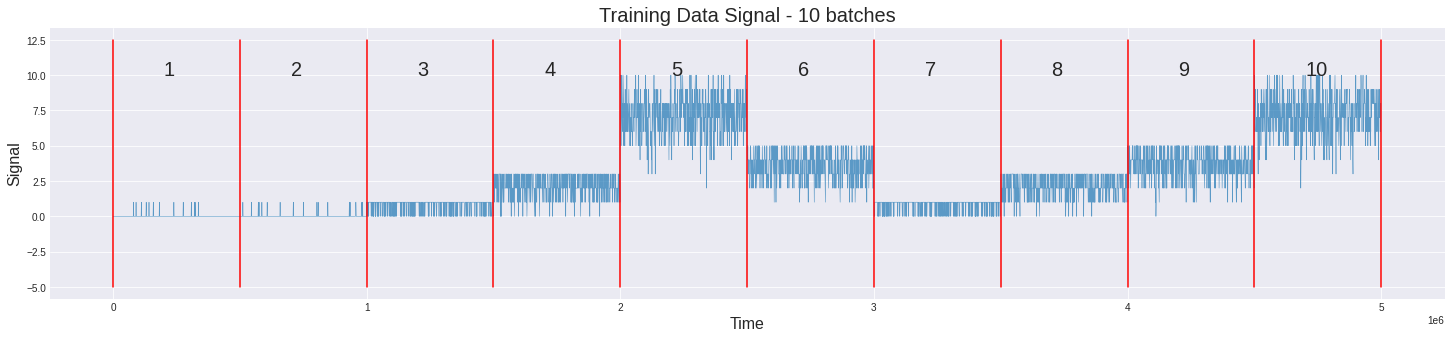

In [10]:
step = 1000
plt.figure(figsize=(25, 5))

# plot open_channels in steps of `step(=1000)`
plt.plot(range(0, len(train), step), train.loc[::step, 'open_channels'], alpha=0.7, linewidth=0.6)

# highlight the start and the end of each batch
for i in range(11):
    plt.plot([i * batch_size, i * batch_size], [-5, 12.5], 'r')

# mark which batch it came from
for i in range(10):
    plt.text(i * batch_size + 200000, 10, str(i + 1), size=20)

plt.xlabel('Time', size=16)
plt.ylabel('Signal', size=16)

plt.title('Training Data Signal - 10 batches',size=20)

plt.show()

Though noise cannod be easily observed, the drift here is easy to see. Drift is time accumulated errors which make horizontal signals skew over time. There's some drift, which appears to be linear, in batch 2. And from batches 7 through 10, there appears to be huge parabolic drift. This drift must be removed for any learning to happen. 

From the `open_channels` plot we find some similar pairs:
1. 1 and 2 with the probability of 1 open channel low. This we call `Group 1`
2. 3 and 7 with the probability of 1 open channel high. This we call `Group 2`
3. 5 and 10 which have open channels from 3 to 10. This as `Group 3`
4. 4 and 8 whith open channels from 0 to 3. This as `Group 4`
5. 6 and 9 with open channels from 0 to 5. Finally, `Group 5`

but from the signals plot the each of these pairs look completely different.
1. There is a sharp peak in 2 which is absent in 1
2. 7, 8, 9, 10 all have parabolic arches which are absent in their counter parts.

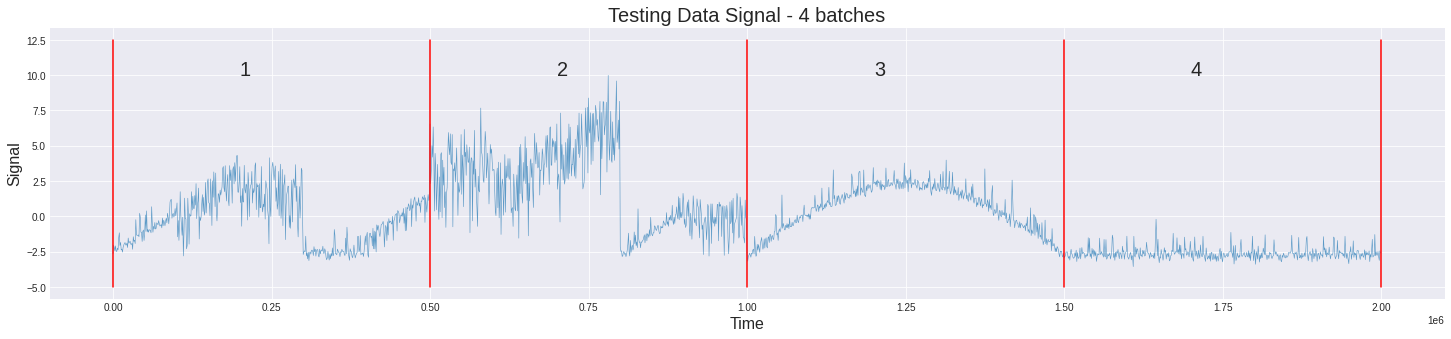

In [11]:
step = 1000
plt.figure(figsize=(25, 5))


# plot open_channels in steps of `step(=1000)` this time for test
plt.plot(range(0, len(test), step), test.loc[::step, 'signal'], linewidth=0.6, alpha=0.7)


# highlight the start and the end of each batch
for i in range(5):
    plt.plot([i * batch_size, i * batch_size], [-5, 12.5], 'r')


# mark which batch it came from
for i in range(4):
    plt.text(i * batch_size + 200000, 10, str(i + 1), size=20)

plt.xlabel('Time', size=16)
plt.ylabel('Signal', size=16)

plt.title('Testing Data Signal - 4 batches',size=20)

plt.show()

There's linear drift in both batches 1 and 2. This drift is more complex than the linear drift from training batch. There is seemingly more than one linear function causing drift, each in parts of the entire batch. Batch 3 has a parabolic drift while batch 4 has no drift.

observations:
1. batch 4 of the test set appears to have come from the same distribution as `Group 1` from the training set
2. the first part of batch 2 in the test set appears to have come from the same distribution as `Group 3` form the training set
3. the first part of batch 1 in the test set appears to have come from the same distribution as `Group 5` from the training set
4. both the last part of batch 1 and of batch 2 seem to come form the `Group 4` distribution of the training set
5. batch 3 of the test set must have come either from `Group 1` or form `Group 2`, but with additional drift which makes it parabolic

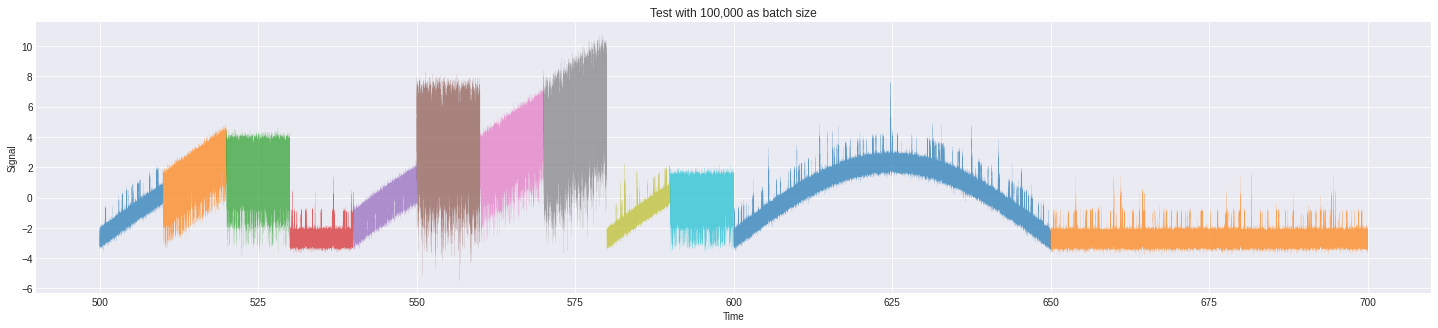

In [12]:
# manually select test batches to better display the differences

test_batch_range = [
    [0, 100000],
    [100000, 200000],
    [200000, 300000],
    [300000, 400000],
    [400000, 500000],
    [500000, 600000],
    [600000, 700000],
    [700000, 800000],
    [800000, 900000],
    [900000, 1000000],
    [1000000, 1500000], # 11th batch (500_000)
    [1500000, 2000000]  # 12th batches (500_000)
]

test_batches = []
for start_batch, end_batch in test_batch_range:
    test_batches.append(test[start_batch: end_batch])
    
plt.figure(figsize=(25, 5))
for batch in test_batches:
    plt.plot(batch['time'], batch['signal'], linewidth=0.1, alpha=0.7)
plt.title('Test with 100,000 as batch size')
plt.ylabel('Signal')
plt.xlabel('Time')
plt.show()

This plot shows clearly the different groups of signal in test data. Thus, the test set can be divided into 12 different batches. First 10 with a batch size of 100,000 and the last 2 with a batch size of 500,000

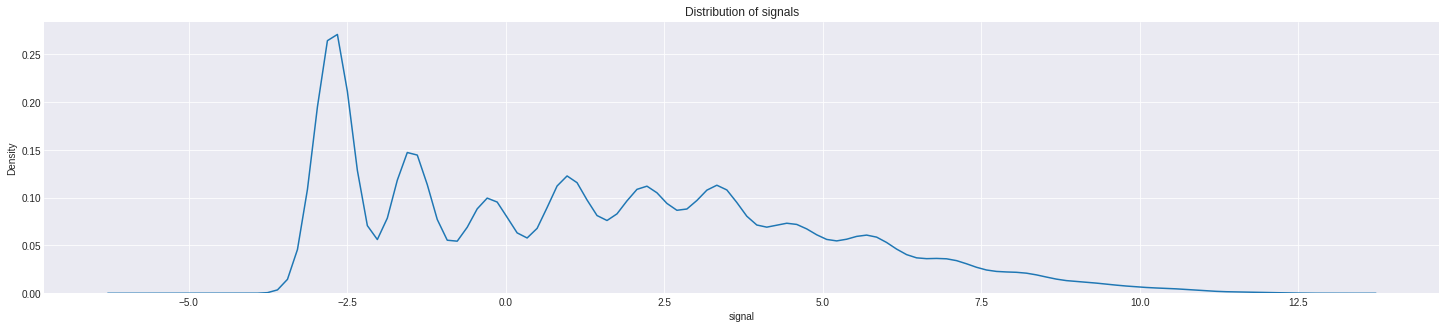

In [13]:
# plot the distribution density of the signal
plt.figure(figsize=(25, 5))
sns.distplot(train['signal'], hist=False)
plt.title('Distribution of signals')
plt.ylabel('Density')
plt.show()

This distribution plot shows that there is no signal reaching below -4mv and 12.5mv. The signals lie between -4mv and 11mv

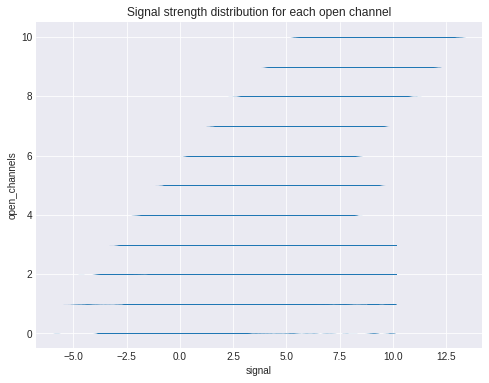

In [14]:
plt.figure(figsize=(8, 6))
sns.scatterplot(train['signal'], train['open_channels'], marker='_', alpha=0.1)
plt.title('Signal strength distribution for each open channel')
plt.show()

This plot shows the signal strength required for each open channel. For there to be 10 open channels, signal strength has to be greater than 5.0, and so on...

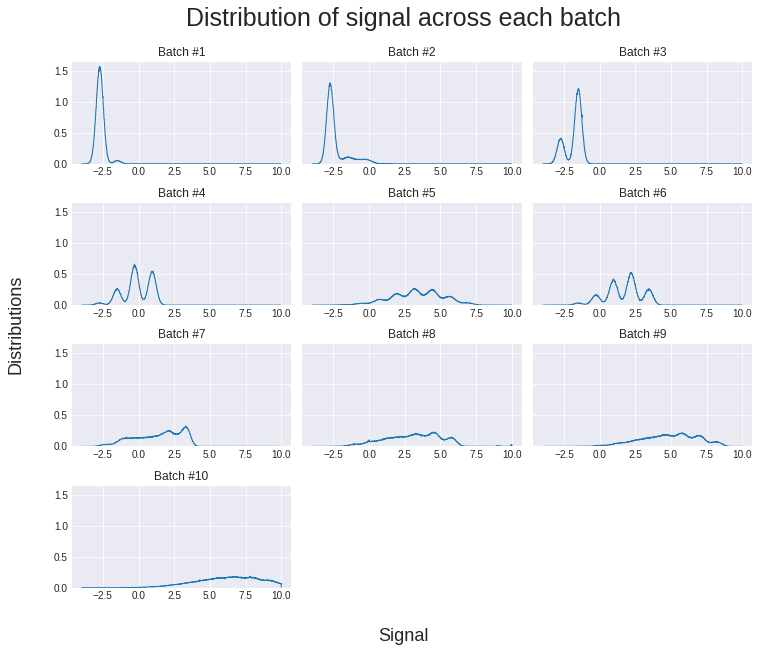

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=3, sharey=True, figsize=(10, 8))

# plot the distribution of open_channels across each batch
start, i = 0, 1

bins = np.linspace(-4, 10, 1000)

# (3 x 4) plot
for row in range(4):
    for col in range(3):
        
        signal = train.iloc[start: start + batch_size]['signal']
        start += batch_size
        
        axes[row, col].hist(signal, bins, density=True, histtype='step')
        axes[row, col].title.set_text(f'Batch #{i}')
        
        i += 1
    

# delete empty plots
fig.delaxes(axes[3, 1])
fig.delaxes(axes[3, 2])

fig.text(0.5, -0.05, 'Signal', ha='center', size=18)
fig.text(-0.05, 0.5, 'Distributions', va='center', rotation='vertical', size=18)
fig.suptitle('Distribution of signal across each batch', y=1.05, size=25)
fig.tight_layout()
plt.show()

As the number of open channels increases, the distribution becomes almost uniform

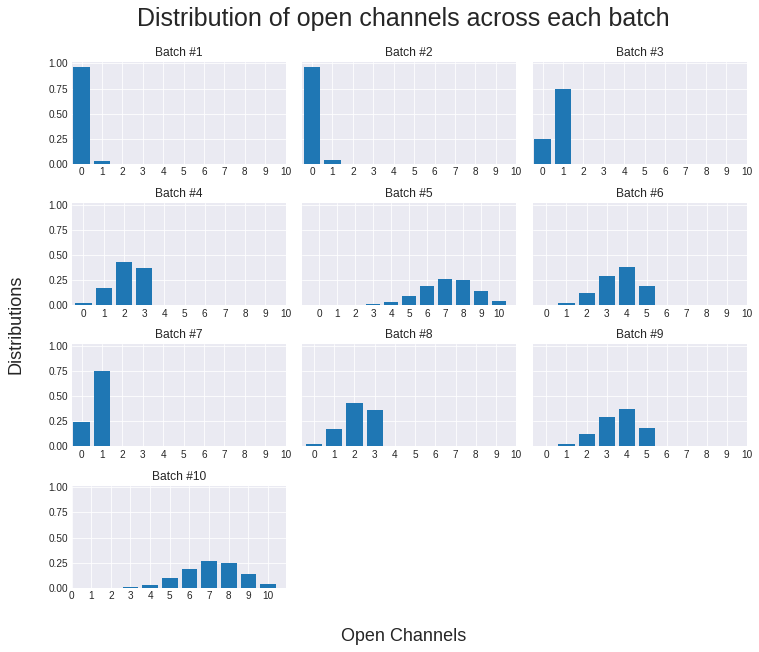

In [16]:
fig, axes = plt.subplots(nrows=4, ncols=3, sharey=True, figsize=(10, 8))

# plot the distribution of open_channels across each batch
start, i = 0, 1

# (3 x 4) plot
for row in range(4):
    for col in range(3):
        
        # get the probabilities of each open_channel occuring
        data = train.iloc[start: start + batch_size]['open_channels'].value_counts(normalize=True, sort=False)
        start += batch_size
        
        axes[row, col].bar(data.index, data.values)
        axes[row, col].title.set_text(f'Batch #{i}')
        
        # xticks contains all 11 classes of open channels even if they are absent
        axes[row, col].set_xticks(range(11))
        
        i += 1
    

# delete empty plots
fig.delaxes(axes[3, 1])
fig.delaxes(axes[3, 2])

fig.text(0.5, -0.05, 'Open Channels', ha='center', size=18)
fig.text(-0.05, 0.5, 'Distributions', va='center', rotation='vertical', size=18)
fig.suptitle('Distribution of open channels across each batch', y=1.05, size=25)
fig.tight_layout()
plt.show()

This plot shows the distribution of open channels across batches. This validates some of our hypotheses. It also shows which batches come from the same disrtibution